In [1]:
from ftplib import FTP
import os
#import shutil
import numpy as np
import zipfile
import pandas 
import geopandas
import time
from matplotlib import pyplot as plt
from shapely.ops import unary_union
#import gzip
#from cycler import cycler

thisyear = 2018
this_state = 'md'
this_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
nDistrictsForBitmaskeration = 8


script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/'
data_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)

scale = 1
map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_cycle = color_cycle + color_cycle
color_cycle = color_cycle + color_cycle

debug = 2
g = 0

print('ok')

ok


# Get congressional district shapefiles

## FTP down from ftp2.census.gov

In [2]:
s = time.time()
print('getting congressional district shapefiles from Census FTP...')
os.chdir(shapefiledir+'CD/')

ftp = FTP('ftp2.census.gov')
ftp.login()
#print(ftp.getwelcome())
ftp.cwd('geo/tiger/TIGER{0:.0f}/CD/'.format(thisyear))
#print(ftp.nlst())

thefilename = 'tl_{0:.0f}_us_cd116.zip'.format(thisyear)
#print(thefilename)
with open(thefilename, 'wb') as f:
    ftp.retrbinary('RETR {0:}'.format(thefilename), f.write)

ftp.quit()
#print('ok')

print('unzipping...')

thezipfile = zipfile.ZipFile(shapefiledir+'CD/tl_{0:.0f}_us_cd116.zip'.format(thisyear))
thezipfile.extractall()
thezipfile.close()
os.remove(shapefiledir+'CD/tl_2018_us_cd116.zip')
#os.listdir()
e = time.time()
g = g + (e-s)
print('Got 1 file in {0:,.0f} seconds!'.format(e-s))
#os.listdir()

getting congressional district shapefiles from Census FTP...
unzipping...
Got 1 file in 82 seconds!


## Load congressional district shapefiles into a GeoDataFrame

In [3]:
s = time.time()
print('reading congressional districts...')
cd_gdf = geopandas.read_file(shapefiledir+'CD/tl_2018_us_cd116.shp')
cd_gdf.loc[:, 'GEOID'] = cd_gdf['GEOID'].apply(lambda x: '50000US'+str(x))
#cd_gdf = cd_gdf.set_index('GEOID')

print('reading helpfel files...')
geo_summary_levels_df = pandas.read_csv(extras_dir+'geo_summary_levels.csv', index_col='SUMLEVEL')
statecodes_df = pandas.read_csv(extras_dir+'statecodes.csv', index_col='STATE')

print('converting to numeric and adding state names and setting index...')

for x in ['STATEFP', 'CD116FP']:
    cd_gdf.loc[:, x] = pandas.to_numeric(cd_gdf[x], errors='coerce', downcast='integer')
for x in ['CDSESSN', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']:
    cd_gdf.loc[:, x] = pandas.to_numeric(cd_gdf[x], errors='coerce')

cd_gdf = cd_gdf.merge(statecodes_df.reset_index(), how='left', left_on='STATEFP', right_on='STATE').set_index('GEOID')


#cd_gdf = cd_gdf.set_index('GEOID')
e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#statecodes_df

#cd_gdf.apply(lambda row: '50000US{0:02d}{1:02d}'.format(int(row['STATEFP']), int(row['CD116FP'])), axis=1)
#cd_gdf[['CD116FP','NAMELSAD','LSAD','CDSESSN','STATE','STUSAB','STATE_NAME','STATENS']]


reading congressional districts...
reading helpfel files...
converting to numeric and adding state names and setting index...
Read 444 districts in 2.0 seconds.


## Load water shapefiles

In [4]:
s = time.time()

if (debug >= 1):
    print('reading water shapefiles in {0:}...'.format(this_state))
this_state_number = statecodes_df[statecodes_df['STUSAB'] == this_state.upper()].index.values[0]

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# if (debug >= 2):
#     print("\n")

for i in range(0, len(water_file_list)):
    if (debug >= 2):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
#     if (debug >= 2):
#         print("\n")        
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#water_gdf.sample(2).T#.dtypes
#print(water_file_list)


reading water shapefiles in md...
	Reading file 1 of 24...
	Reading file 11 of 24...
	Reading file 21 of 24...
	Reading file 24 of 24...
Read 15,012 bodies of water in 3 seconds!


## Load census tracts

In [5]:
s = time.time()
tract_file_list = [shapefiledir+'TRACT/'+x for x in os.listdir(shapefiledir+'TRACT/') if ((x[-4:] == '.shp') and ('{0:.0f}'.format(this_state_number) in x))]

#this_state_number = statecodes_df[statecodes_df['STUSAB'] == this_state.upper()].index.values[0]

tract_gdf = geopandas.GeoDataFrame()

# # if (debug >= 1):
# #     print('reading census tracts in {0:}...'.format(this_state))
for i in range(0, len(tract_file_list)):
    #print(tract_file_list[i],'...')
    if (debug >= 2):
        if ((np.mod(i,10) == 0) | (i == len(tract_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(tract_file_list)))
    tract_gdf_i = geopandas.read_file(tract_file_list[i])
    tract_gdf = pandas.concat((tract_gdf, tract_gdf_i), axis=0, sort=False)

print('changing tract name from string to number...')
tract_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
tract_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOIDs as index...')
tract_gdf.loc[:, 'GEOID'] = tract_gdf['GEOID'].apply(lambda x: '14000US'+str(x))
tract_gdf = tract_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census tracts in {1:,.1f} seconds!'.format(len(tract_gdf), e-s))
# #tract_gdf.plot()

tract_gdf.sample(1).T

	Reading file 1 of 1...
changing tract name from string to number...
assigning GEOIDs as index...
Read 1,406 census tracts in 0.5 seconds!


GEOID,14000US24043011302
STATEFP,24
COUNTYFP,043
TRACTCE,011302
NAME,113.02
NAMELSAD,Census Tract 113.02
MTFCC,G5020
FUNCSTAT,S
ALAND,63571050
AWATER,107704
INTPTLAT,+39.5774080


## Load block groups

In [6]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp') and ('{0:.0f}'.format(this_state_number) in x))]
bg_gdf = geopandas.GeoDataFrame()

if (debug >= 1):
    print('reading census block groups in {0:}...'.format(this_state))
for i in range(0, len(bg_file_list)):
    if (debug >= 2):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group number to numeric...')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))


reading census block groups in md...
	Reading file 1 of 1...
converting block group number to numeric...
assigning GEOID as index...
Read 3,926 census block groups in 1.2 seconds!


## Get population data, and join onto shapefiles

In [7]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(data_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')
print('Entries for {0:,.0f} geographies: {1:,.0f} tracts and {2:,.0f} block groups...'.format(len(acs5_estimates_df), len(acs5_estimates_df[acs5_estimates_df.index.map(lambda x: int(x[0:3]) == 140)]), len(acs5_estimates_df[acs5_estimates_df.index.map(lambda x: int(x[0:3]) == 150)])))

print('joining population data onto tract shapefiles...')
tract_gdf = tract_gdf.join(acs5_estimates_df[acs5_estimates_df['STUSAB'] == this_state][['B01001_001', 'Geography Name']], how='left')
tract_gdf = tract_gdf.rename(columns={'B01001_001': 'total_population'})

print('joining population data onto tract shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[acs5_estimates_df['STUSAB'] == this_state][['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

# print('backing up everything...')
# cd_gdf_bk = cd_gdf
# water_gdf_bk = water_gdf
# tract_gdf_bk = tract_gdf
# bg_gdf_bk = bg_gdf

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} census tracts and {1:,.0f} block groups in {2:,.0f} seconds!'.format(len(tract_gdf), len(bg_gdf), e-s))


reading ACS5 census data for 2018...
Entries for 290,795 geographies: 73,056 tracts and 217,739 block groups...
joining population data onto tract shapefiles...
joining population data onto tract shapefiles...

added ACS5 census data to 1,406 census tracts and 3,926 block groups in 2 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

## Tracts that overlap only a single district

In [8]:
s = time.time()

# print('getting from backup everything...')
# cd_gdf = cd_gdf_bk
# water_gdf = water_gdf_bk
# tract_gdf = tract_gdf_bk
# bg_gdf = bg_gdf_bk

print('matching tracts to congressional districts...')
tract_gdf = tract_gdf.assign(congressional_districts_bitmask_numeral = np.nan)

cnt = 0
for ix, thisrow in tract_gdf.iterrows():
    if ((np.mod(cnt,100) == 0) | (cnt == len(tract_gdf) - 1)):
        print('processing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(tract_gdf)))
    bitmasker = 0
    for jx, thatrow in cd_gdf[cd_gdf['STATEFP'] == this_state_number].sort_values(by='CD116FP').iterrows():        
        if (thisrow.geometry.intersects(thatrow.geometry)):
            if (tract_gdf[tract_gdf.index == ix].to_crs(this_crs).geometry.values[0].intersection(cd_gdf[cd_gdf.index == jx].to_crs(this_crs).geometry.values[0]).area >= overlap_area_tract_tol):    
                #print('Intersects District {0:.0f} with area {1:,.0f} m^2'.format(thatrow['CD116FP'], tract_gdf[tract_gdf.index == ix].to_crs(this_crs).geometry.values[0].intersection(cd_gdf[cd_gdf.index == jx].to_crs(this_crs).geometry.values[0]).area))
                bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
    tract_gdf.loc[ix, 'congressional_districts_bitmask_numeral'] = bitmasker
    cnt = cnt + 1

print('converting to bitmask...')
tract_gdf = tract_gdf.assign(congressional_districts_bitmask = tract_gdf['congressional_districts_bitmask_numeral'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1]))

print('counting number of districts overlapped...')
tract_gdf = tract_gdf.assign(nDistricts = tract_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1")))

print('Districts per tract for {0:}...'.format(this_state))
print(tract_gdf.groupby('nDistricts').size())
print('\n')

assembler_gdf = tract_gdf[tract_gdf['nDistricts'] == 1]
assembler_gdf = assembler_gdf.drop('nDistricts', axis=1)
print('Assembled {0:,.0f} tracts...'.format(len(assembler_gdf)))

assembler_gdf = assembler_gdf.assign(BLKGRPCE = np.nan)
bg_finding_list = tract_gdf[tract_gdf['nDistricts'] > 1].apply(lambda row: '15000US{0:}{1:}{2:}'.format(row['STATEFP'],row['COUNTYFP'],row['TRACTCE']), axis=1).tolist()
assembler_gdf = pandas.concat((assembler_gdf,bg_gdf[bg_gdf.index.map(lambda x: x[:-1] in bg_finding_list)]), axis=0, sort=False)
print('Added {0:,.0f} block groups for a total of {1:,.0f} rows...'.format(len(assembler_gdf['BLKGRPCE'].dropna()), len(assembler_gdf)))

e = time.time()
g = g + (e-s)
print('Matched {0:,.0f} single-overlapping tracts to congressional districts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))



matching tracts to congressional districts...
processing row 1 of 1,406...
processing row 101 of 1,406...
processing row 201 of 1,406...
processing row 301 of 1,406...
processing row 401 of 1,406...
processing row 501 of 1,406...
processing row 601 of 1,406...
processing row 701 of 1,406...
processing row 801 of 1,406...
processing row 901 of 1,406...
processing row 1,001 of 1,406...
processing row 1,101 of 1,406...
processing row 1,201 of 1,406...
processing row 1,301 of 1,406...
processing row 1,401 of 1,406...
processing row 1,406 of 1,406...
converting to bitmask...
counting number of districts overlapped...
Districts per tract for md...
nDistricts
1    1194
2     204
3       7
4       1
dtype: int64


Assembled 1,194 tracts...
Added 614 block groups for a total of 1,808 rows...
Matched 1,808 single-overlapping tracts to congressional districts in 3 minutes 14 seconds!


## For tracts that overlap multiple districts, match block groups


In [9]:
s = time.time()

print('matching block groups...')
cnt = 0
total_rows_to_process = len(assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'].isnull()])
for ix, thisrow in assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'].isnull()].iterrows():
    if ((np.mod(cnt,100) == 0) | (cnt == len(tract_gdf) - 1)):
        print('\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, total_rows_to_process))
    bitmasker = 0
    for jx, thatrow in cd_gdf[cd_gdf['STATEFP'] == this_state_number].sort_values(by='CD116FP').iterrows():        
        if (thisrow.geometry.intersects(thatrow.geometry)):
            if (assembler_gdf[assembler_gdf.index == ix].to_crs(this_crs).geometry.values[0].intersection(cd_gdf[cd_gdf.index == jx].to_crs(this_crs).geometry.values[0]).area >= overlap_area_bg_tol):
                #print('Intersects District {0:.0f} with area {1:,.0f} m^2'.format(thatrow['CD116FP'], tract_gdf[tract_gdf.index == ix].to_crs(this_crs).geometry.values[0].intersection(cd_gdf[cd_gdf.index == jx].to_crs(this_crs).geometry.values[0]).area))
                bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
    assembler_gdf.loc[ix, 'congressional_districts_bitmask_numeral'] = bitmasker
    cnt = cnt + 1

print('converting to bitmask...')
assembler_gdf = assembler_gdf.assign(congressional_districts_bitmask = assembler_gdf['congressional_districts_bitmask_numeral'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1]))

print('counting number of districts overlapped...')
assembler_gdf = assembler_gdf.assign(nDistricts = assembler_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1")))

e = time.time()
g = g + (e-s)
print('Matched a total of {0:,.0f} geographies in {1:,.1f} seconds!'.format(len(assembler_gdf['congressional_districts_bitmask_numeral'].dropna()),e-s))
#assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'].isnull()]

print(assembler_gdf.groupby('nDistricts').size())

matching block groups...
	processing row 1 of 614...
	processing row 101 of 614...
	processing row 201 of 614...
	processing row 301 of 614...
	processing row 401 of 614...
	processing row 501 of 614...
	processing row 601 of 614...
converting to bitmask...
counting number of districts overlapped...
Matched a total of 1,808 geographies in 105.6 seconds!
nDistricts
1    1538
2     268
3       1
4       1
dtype: int64


# Assign final congressional district to each tract or block group

## Assign final district numbers to geometries that overlap only one district

In [10]:
s = time.time()
print('assigning final congressional district to the tracts/blockgroups that overlap only one district')
assembler_gdf = assembler_gdf.assign(congressional_district = np.nan)
assembler_gdf.loc[assembler_gdf['nDistricts'] == 1, 'congressional_district'] = assembler_gdf[assembler_gdf['nDistricts'] == 1]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

assembler_gdf[assembler_gdf['nDistricts'] > 2][['COUNTYFP','TRACTCE','BLKGRPCE','Geography Name','congressional_districts_bitmask','nDistricts']].sort_values(by='nDistricts', ascending=False)
# overlaps 4 districts: 15000US240037406031, Anne Arundel, 7406.03, BG 1, overlaps 2,3,4,5
# overlaps 3 districts: 15000US240037407022, Anne Arundel, 7407.02, BG 2, overlaps 3,4,5

# Overlaps 2 districts: 268 block groups
len(assembler_gdf[assembler_gdf['nDistricts'] == 2])

e = time.time()
g = g + (e-s)
print('Assigned final district values for {0:,.0f} of {1:,.0f} geometries...'.format(len(assembler_gdf['congressional_district'].dropna()), len(assembler_gdf)))

assembler_gdf[assembler_gdf['nDistricts'] == 2].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)
# 1 and 2: 29
# 1 and 7: 8
# 1 and 8: 1
# 2 and 3: 53
# 2 and 7: 27
# 3 and 4: 16
# 3 and 5: 1
# 3 and 7: 48
# 3 and 8: 18
# 4 and 5: 36
# 6 and 8: 42


assigning final congressional district to the tracts/blockgroups that overlap only one district
Assigned final district values for 1,538 of 1,808 geometries...


congressional_districts_bitmask
x11000000    29
x10000010     8
x10000001     1
x01100000    53
x01000010    17
x00110000    16
x00101000     1
x00100010    48
x00100001    18
x00011000    35
x00000101    42
dtype: int64

### Where should the four-timer (GEOID = '15000US240037406031') get assigned?

Examining GEOID = 15000US240037406031: Block Group 1, Census Tract 7406.03, Anne Arundel County, Maryland...
	Total area: 35,686,607 m^2...
Overlap with District 2: 1,576,395 m^2 (4.4%)
Overlap with District 3: 18,557,849 m^2 (52.0%)
Overlap with District 4: 15,442,112 m^2 (43.3%)
Overlap with District 5: 110,250 m^2 (0.3%)


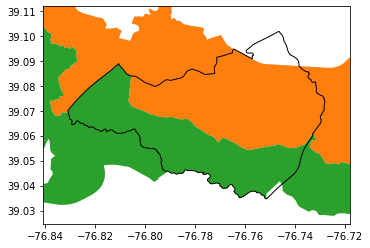



GEOID = 15000US240037406031 will be assigned to District 3
Assigned final district to GEOID = 15000US240037406031 in 6.2 seconds!


In [11]:
s = time.time()
this_geoid = '15000US240037406031'
# OVERLAPS 4 DISTRICTS: Districts 2, 3, 4, 5
#for ix, thisrow in 
for ix, thisrow in assembler_gdf[assembler_gdf.index == this_geoid].iterrows():
    print('Examining GEOID = {0:}: {1:}...'.format(ix, thisrow['Geography Name']))
    total_area = assembler_gdf.to_crs(this_crs).loc[this_geoid].geometry.area
    print('\tTotal area: {0:,.0f} m^2...'.format(total_area))
    for d in [2,3,4,5]:
        this_overlap_area = assembler_gdf.to_crs(this_crs)[assembler_gdf.index == ix].geometry.apply(lambda x: x.intersection(
            cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == d)].to_crs(this_crs).geometry.values[0]
                    )
               ).area.values[0]
        
        print('Overlap with District {0:.0f}: {1:,.0f} m^2 ({2:.1%})'.format(d,this_overlap_area,this_overlap_area/total_area))


map_buffer = 0.01
fig,ax = plt.subplots()
#cd_gdf[cd_gdf['STATEFP'] == this_state_number].plot(ax=ax)

#cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color=color_cycle[0])
cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color=color_cycle[1])
cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color=color_cycle[2])
#cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color=color_cycle[3])
assembler_gdf[assembler_gdf.index == this_geoid].plot(ax=ax, color='none', edgecolor='black')
#water_gdf.plot(ax=ax, color='orange')
plt.xlim(assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['minx'].values[0] - map_buffer,assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['maxx'].values[0] + map_buffer)
plt.ylim(assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['miny'].values[0] - map_buffer,assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['maxy'].values[0] + map_buffer)
plt.show()
print('\n')
print('GEOID = {0:} will be assigned to District {1:.0f}'.format(this_geoid, 3))
assembler_gdf.loc['15000US240037406031', 'congressional_district'] = 3

e = time.time()
g = g + (e-s)
print('Assigned final district to GEOID = {0:} in {1:.1f} seconds!'.format(this_geoid, e-s))


### Where should the three-timer (GEOID = '15000US240037407022') get assigned?

Examining GEOID = 15000US240037407022: Block Group 2, Census Tract 7407.02, Anne Arundel County, Maryland...
	Total area: 19,375,046 m^2...
Overlap with District 2: 0 m^2 (0.0%)
Overlap with District 3: 2,256,945 m^2 (11.6%)
Overlap with District 4: 6,569,402 m^2 (33.9%)
Overlap with District 5: 10,548,700 m^2 (54.4%)


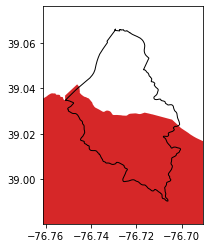

GEOID = 15000US240037407022 will be assigned to District 5
Assigned final district to GEOID = 15000US240037407022 in 6.4 seconds!


In [12]:
s = time.time()
this_geoid = '15000US240037407022'

# OVERLAPS 4 DISTRICTS: Districts 3, 4, 5
for ix, thisrow in assembler_gdf[assembler_gdf.index == this_geoid].iterrows():
    print('Examining GEOID = {0:}: {1:}...'.format(ix, thisrow['Geography Name']))
    total_area = assembler_gdf.to_crs(this_crs).loc[this_geoid].geometry.area
    print('\tTotal area: {0:,.0f} m^2...'.format(total_area))
    for d in [2,3,4,5]:
        this_overlap_area = assembler_gdf.to_crs(this_crs)[assembler_gdf.index == ix].geometry.apply(lambda x: x.intersection(
            cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == d)].to_crs(this_crs).geometry.values[0]
                    )
               ).area.values[0]
        
        print('Overlap with District {0:.0f}: {1:,.0f} m^2 ({2:.1%})'.format(d,this_overlap_area,this_overlap_area/total_area))


map_buffer = 0.01
fig,ax = plt.subplots()
#cd_gdf[cd_gdf['STATEFP'] == this_state_number].plot(ax=ax)

#cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color=color_cycle[1])
#cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color=color_cycle[2])
cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color=color_cycle[3])
assembler_gdf[assembler_gdf.index == this_geoid].plot(ax=ax, color='none', edgecolor='black')
#water_gdf.plot(ax=ax, color='orange')

plt.xlim(assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['minx'].values[0] - map_buffer,assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['maxx'].values[0] + map_buffer)
plt.ylim(assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['miny'].values[0] - map_buffer,assembler_gdf[assembler_gdf.index == this_geoid].geometry.bounds['maxy'].values[0] + map_buffer)
plt.show()

print('GEOID = {0:} will be assigned to District {1:.0f}'.format(this_geoid, 5))
assembler_gdf.loc['15000US240037407022', 'congressional_district'] = 5


# print('backing up assembled geographies with some final congressional districts assigned...')
# assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Assigned final district to GEOID = {0:} in {1:.1f} seconds!'.format(this_geoid, e-s))


# Assign final districts to tracts that overlap exactly 2 districts

In [13]:
s = time.time()
print('assigning final congressional districts to block groups split among two districts...')
# print('getting from backup...')
# print('\n')
# assembler_gdf = assembler_gdf_bk
# #assembler_gdf[assembler_gdf['congressional_district'].isnull()].groupby('nDistricts').size()
for a in range(1,nDistrictsForBitmaskeration):
    print('Finding geometries that overlap with District {0:.0f} and one other...'.format(a))
    for b in range(a+1,nDistrictsForBitmaskeration+1):
        comparitor = 2**(a-1)+2**(b-1)
        if (len(assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'] == comparitor]) == 0):
            pass
#            print('\tDistrict {0:.0f}: no matches found...'.format(b))            
        else:
            comparitor = 2**(a-1) + 2**(b-1)
#            print('\tDISTRICT {0:.0f}: Found {1:.0f} geometries that overlap...'.format(b, len(assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'] == comparitor])))
            for ix, thisrow in assembler_gdf[assembler_gdf['congressional_districts_bitmask_numeral'] == comparitor].iterrows():
#                print('\t\tGeometry {0:}: {1:}...'.format(ix, thisrow['Geography Name']))
                area_total = thisrow.geometry.area
                #area_total_m2 = assembler_gdf.to_crs(this_crs).loc[ix].geometry.area
                a_intersection_area = thisrow.geometry.intersection(cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == a)].geometry.values[0]).area
                b_intersection_area = thisrow.geometry.intersection(cd_gdf[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == b)].geometry.values[0]).area
                #a_intersection_area_m2 = assembler_gdf.to_crs(this_crs).loc[ix].geometry.intersection(cd_gdf.to_crs(this_crs)[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == a)].geometry.values[0]).area                
                #b_intersection_area_m2 = assembler_gdf.to_crs(this_crs).loc[ix].geometry.intersection(cd_gdf.to_crs(this_crs)[(cd_gdf['STATEFP'] == this_state_number) & (cd_gdf['CD116FP'] == b)].geometry.values[0]).area
                a_pct = a_intersection_area / area_total
                b_pct = b_intersection_area / area_total
                #print('\t\t\tIntersection with District {0:.0f} area: {1:,.0f} m^2 ({2:.1%} of total area)'.format(a, a_intersection_area_m2, a_pct))
                #print('\t\t\tIntersection with District {0:.0f} area: {1:,.0f} m^2 ({2:.1%} of total area)'.format(b, b_intersection_area_m2, b_pct))
                #if (a_intersection_area_m2 >= b_intersection_area_m2):
                if (a_intersection_area >= b_intersection_area):
                    final_district = a
#                    print('\t\t\tAssigning to District {0:.0f} ({1:.1%} of area)'.format(a,a_pct))
                else:
                    final_district = b
#                    print('\t\t\tAssigning to District {0:.0f} ({1:.1%} of area)'.format(b,b_pct))
                #print('\n')
                assembler_gdf.loc[ix, 'congressional_district'] = final_district

print('renaming DataFrame to be more descriptive...')
approximate_congressional_districts_gdf = assembler_gdf

print('uniting geometries into single row for each approximate congressional district...')
new_cd_gdf = geopandas.GeoDataFrame(data=None, columns=['GEOID', 'STATE', 'CD116FP', 'total_population', 'geometry'], crs=approximate_congressional_districts_gdf.crs, geometry='geometry')
for i in range(1,nDistrictsForBitmaskeration+1):
    new_row_list = ['59999US{0:02d}{1:02d}'.format(24,i),24,i]
    this_district_total_population = approximate_congressional_districts_gdf[approximate_congressional_districts_gdf['congressional_district'] == i]['total_population'].sum()    
    united_geometry = unary_union(approximate_congressional_districts_gdf[approximate_congressional_districts_gdf['congressional_district'] == i].geometry.tolist())
    
    new_row_list.append(this_district_total_population)
    new_row_list.append(united_geometry)
    new_cd_gdf.loc[i] = new_row_list
new_cd_gdf = new_cd_gdf.set_index('GEOID', drop=True)


print('backing up...')
approximate_congressional_districts_gdf_bk = approximate_congressional_districts_gdf

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} seconds!'.format(e-s))



assigning final congressional districts to block groups split among two districts...
Finding geometries that overlap with District 1 and one other...
Finding geometries that overlap with District 2 and one other...
Finding geometries that overlap with District 3 and one other...
Finding geometries that overlap with District 4 and one other...
Finding geometries that overlap with District 5 and one other...
Finding geometries that overlap with District 6 and one other...
Finding geometries that overlap with District 7 and one other...
renaming DataFrame to be more descriptive...
uniting geometries into single row for each approximate congressional district...
backing up...
Done in 23 seconds!


# Calculate population of each new district

In [14]:
# print('POPULATIONS OF APPROXIMATE CONGRESSIONAL DISTRICTS\n')
# for ix, thisrow in approximate_congressional_districts_gdf.groupby('congressional_district')['total_population'].sum().iteritems():
#     print('District {0:.0f} population: {1:,.0f}'.format(ix,thisrow))
for ix, thisrow in new_cd_gdf.iterrows():
    print('DISTRICT {0:} population: {1:,.0f}'.format(thisrow['CD116FP'], thisrow['total_population']))



DISTRICT 1 population: 736,983
DISTRICT 2 population: 765,739
DISTRICT 3 population: 749,389
DISTRICT 4 population: 748,905
DISTRICT 5 population: 762,091
DISTRICT 6 population: 763,839
DISTRICT 7 population: 713,179
DISTRICT 8 population: 763,310


In [15]:
print('DONE! TOTAL TIME {0:,.0f} hours {1:,.0f} minutes {2:,.0f} seconds!'.format(np.floor(g/3600), np.floor(g/60), np.floor(g%60)))


DONE! TOTAL TIME 0 hours 7 minutes 7 seconds!


getting from backup...
plotting...


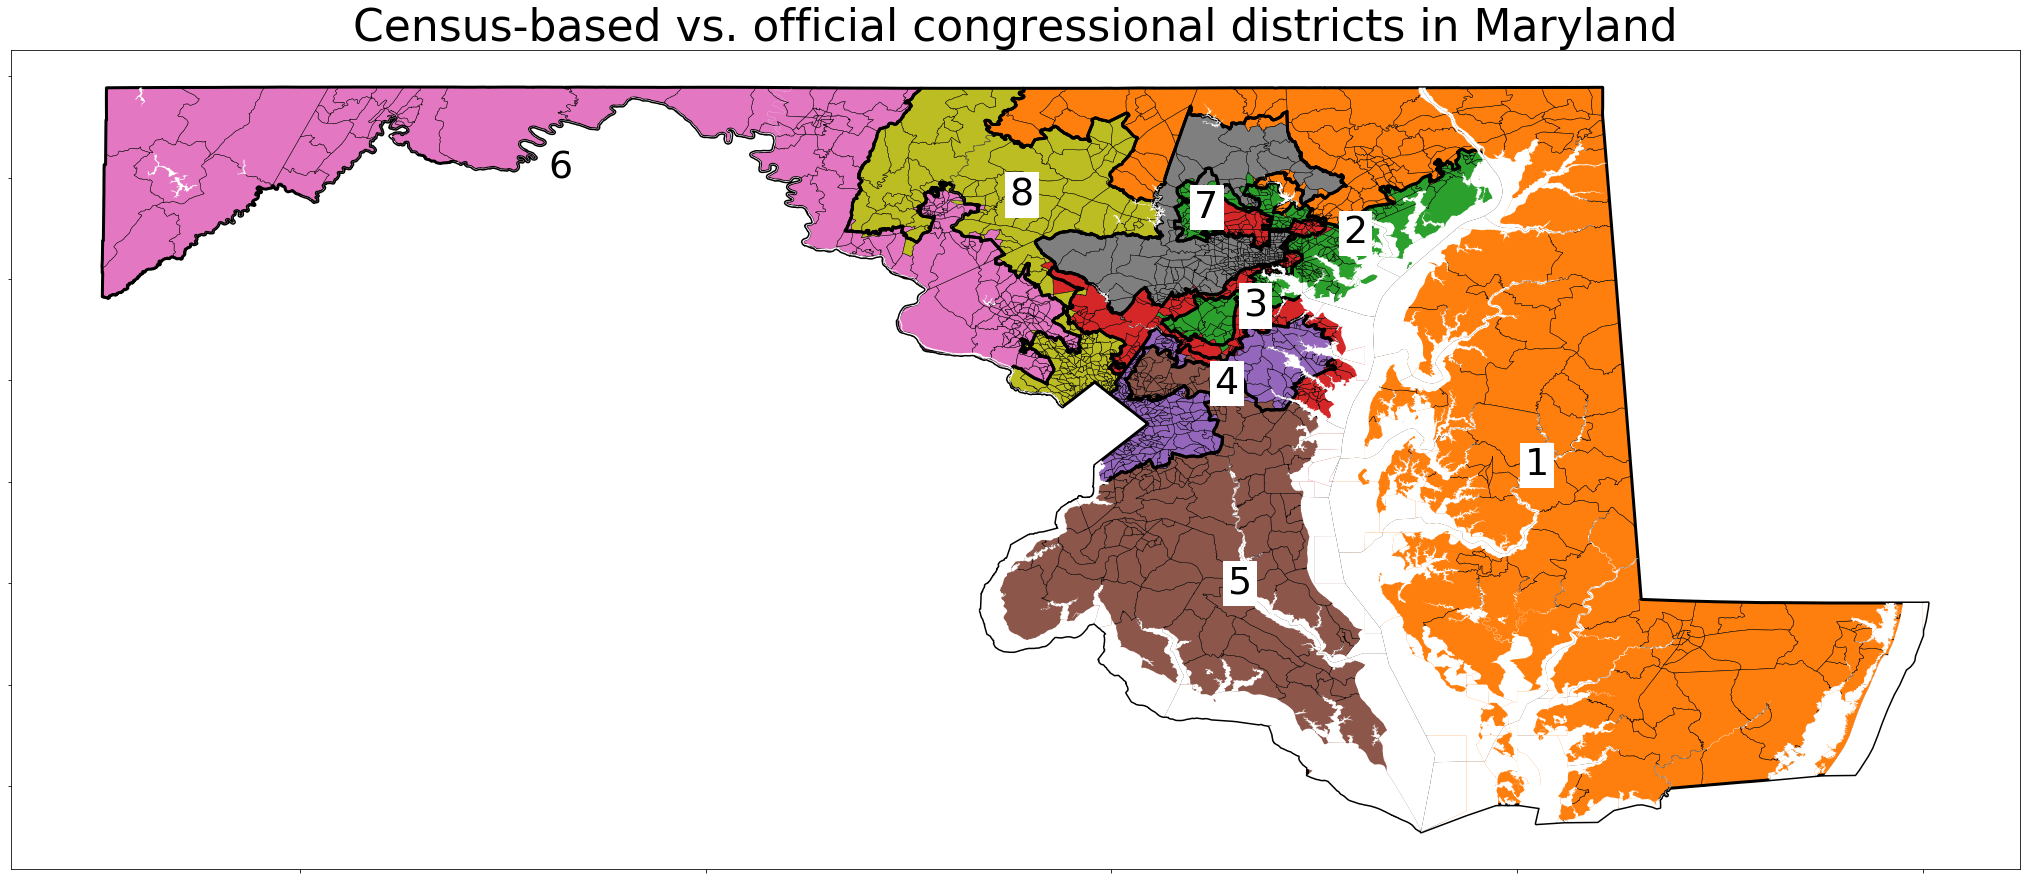

In [16]:
print('getting from backup...')
approximate_congressional_districts_gdf = approximate_congressional_districts_gdf_bk

print('plotting...')
fig, ax = plt.subplots(1,1, figsize=(36*scale, 48*scale))
for i in range(1,nDistrictsForBitmaskeration+1):
    approximate_congressional_districts_gdf[approximate_congressional_districts_gdf['congressional_district'] == i].plot(ax=ax, color=color_cycle[i], edgecolor='black', linewidth=0.5)
cd_gdf[cd_gdf['STATEFP'] == this_state_number].plot(ax=ax, color='none', edgecolor='black', linewidth=3)
water_gdf[water_gdf['AWATER'] >= 1000000].plot(ax=ax, color='white')

for ix, thisrow in cd_gdf[cd_gdf['STATEFP'] == 24].iterrows():
    plt.annotate(int(thisrow['CD116FP']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
                 fontsize=38, backgroundcolor='white')

ax.set_xticklabels([])
ax.set_yticklabels([])
#plt.legend()
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.title('Census-based vs. official congressional districts in {0:}'.format(statecodes_df[statecodes_df['STUSAB'].apply(lambda x: x.lower()) == this_state]['STATE_NAME'].values[0]), fontsize=44)

# plt.xlim([-77.8,-76])
# plt.ylim([38.6,39.8])
plt.show()
#water_gdf.sample(2).T
#approximate_congressional_districts_gdf.columns

In [17]:
# s = time.time()
# # print('getting from backup...')
# # cd_gdf = cd_gdf_bk
# # water_gdf = water_gdf_bk
# # tract_gdf = tract_gdf_bk
# # bg_gdf = bg_gdf_bk
# map_buffer = 0.1

# #gdf = cd_gdf[(cd_gdf['STUSAB'] == '{0}'.format(this_state.upper()))]

# d = 1

# fig, ax = plt.subplots(1,1,figsize=(40*scale,36*scale))

# #for i in [1]:#range(1,nDistrictsForBitmaskeration):
# for i in [1]:
#     cd_gdf[(cd_gdf['STUSAB'] == '{0}'.format(this_state.upper())) & (cd_gdf['CD116FP'] == d)].plot(ax=ax, color=color_cycle[d])

# tract_gdf[tract_gdf['congressional_districts_bitmask'].apply(lambda x: x[d]=='1')].plot(ax=ax, color='none', edgecolor='black', linewidth=2*scale)

# # tract_gdf[tract_gdf.geometry.intersects(cd_gdf[
# #     (cd_gdf['STATEFP'] == this_state_number)
# #     & (cd_gdf['CD116FP'] == 1)
# # ].geometry.values[0])].plot(ax=ax, color='none', edgecolor='black', linewidth=0.8*scale)


# water_gdf.plot(ax=ax,color='white')


# limit_west = np.min(
#     cd_gdf[
#         (cd_gdf['STUSAB'] == '{0}'.format(this_state.upper())) 
#         & (cd_gdf['CD116FP'] == d)
#     ].bounds['minx'].tolist()) - map_buffer

# limit_east = np.max(
#     cd_gdf[
#         (cd_gdf['STUSAB'] == '{0}'.format(this_state.upper())) 
#         & (cd_gdf['CD116FP'] == d)
#     ].bounds['maxx'].tolist()) + map_buffer

# limit_south = np.min(
#     cd_gdf[
#         (cd_gdf['STUSAB'] == '{0}'.format(this_state.upper())) 
#         & (cd_gdf['CD116FP'] == d)
#     ].bounds['miny'].tolist()) - map_buffer


# limit_north = np.min(
#     cd_gdf[
#         (cd_gdf['STUSAB'] == '{0}'.format(this_state.upper())) 
#         & (cd_gdf['CD116FP'] == d)
#     ].bounds['maxy'].tolist()) + map_buffer

# limit_south = 39.3
# limit_north = 39.75
# limit_west = -77.4
# limit_east = -76
# # limit_west = np.min(tract_gdf.bounds['minx'].tolist()) - map_buffer
# # limit_east = np.max(tract_gdf.bounds['maxx'].tolist()) + map_buffer
# # limit_south = np.min(tract_gdf.bounds['miny'].tolist()) - map_buffer
# # limit_north = np.max(tract_gdf.bounds['maxy'].tolist()) + map_buffer

# plt.xlim([limit_west, limit_east])
# plt.ylim([limit_south, limit_north])

# overlapping_tracts = tract_gdf[
#     (tract_gdf['congressional_districts_bitmask'].apply(lambda x: x[d]=='1'))
#     & (tract_gdf['congressional_districts_bitmask_numeral'] != 1)
#     & ((tract_gdf.geometry.centroid.x >= limit_west) & (tract_gdf.geometry.centroid.x <= limit_east))
#     & ((tract_gdf.geometry.centroid.y >= limit_south) & (tract_gdf.geometry.centroid.x <= limit_north))].index.values.tolist()


# # for ix, thisrow in tract_gdf[
# #     (tract_gdf['congressional_districts_bitmask'].apply(lambda x: x[d]=='1'))
# #     & (tract_gdf['congressional_districts_bitmask_numeral'] != 1)#.apply(lambda x: np.log2(float(x)) != 
# #     & ((tract_gdf.geometry.centroid.x >= limit_west) & (tract_gdf.geometry.centroid.x <= limit_east))
# #     & ((tract_gdf.geometry.centroid.y >= limit_south) & (tract_gdf.geometry.centroid.x <= limit_north))
# # ].iterrows():

# for ix, thisrow in tract_gdf[tract_gdf.index.isin(overlapping_tracts)].iterrows():
#     annotator = thisrow['NAME']
#     plt.annotate(annotator, 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
#                  fontsize=28*scale,
#                  backgroundcolor='white'
#                 )

# plt.xticks(fontsize=36*scale)
# plt.yticks(fontsize=36*scale)

# # ax.xaxis.set_visible(False)
# # ax.yaxis.set_visible(False)

# plt.show()


# e = time.time()
# g = g + (e-s)
# print('Graph: {0:,.1f} seconds...'.format(e-s))
# print('Total time: {0:,.0f} seconds!'.format(g))



